# Scanner characterization EDA

# Imports

In [2]:
import re
import statistics
import ruamel.yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyprojroot import here
from typing import Iterable

sns.set_style("ticks",{'axes.grid' : True})

# Load data

In [3]:
BASE_PATH = here().joinpath("scanner_params")
FILE_PATH = BASE_PATH.joinpath("scanners_params.csv").resolve()
SIMSET_MATERIALS = BASE_PATH.joinpath("simset_materials.csv").resolve()
STATS_PARAMS_FILE = BASE_PATH.joinpath("params_stats.csv")
DROP_COLS = [
    'TOF', 
    'PSF Correction', 
    'Missing parameters',
    'References', 
    'Notes',
    'reconstruction parameters',
    'YAML Configuration'
]
FIELDS = [
    'Scanner Name',
    'average_doi',
    'z_crystal_size',
    'crystal_thickness',
    'transaxial_crystal_size',
    'simset_material',
    'scanner_radius',
    'num_td_bins',
    'num_rings',
    'num_aa_bins',
    'min_energy_window',
    'max_energy_window',
    'energy_resolution',
    'coincidence_window',
    'axial_fov'
]
df_materials = pd.read_csv(SIMSET_MATERIALS)
df = pd.read_csv(FILE_PATH, usecols=FIELDS)
df = df.merge(df_materials, how="left", left_on="simset_material", right_on="Attenuation Index")
df["Material, Att. Idx."] = df["Material"].astype(str) + ', ' + df["Attenuation Index"].astype(str) 


## Detector gap

In [9]:
df\
.assign(detector_gap=(df["axial_fov"] - df["num_rings"] * df["z_crystal_size"]) / (df["num_rings"] - 1))\
.loc[:, ["Scanner Name", "detector_gap"]]

,Scanner Name,detector_gap
0,Siemens Biograph mCT,0.019608
1,Siemens mMR,0.003175
2,GE Advance,0.036471
3,GE Discovery ST,0.025217
4,GE Discovery STE,0.025217
5,Philips Vereos,0.010256
6,Philips Gemini,0.009302
7,Philips Gemini GXL,0.251852
8,Discovery IQ,0.020513
9,Discovery MI,0.912000


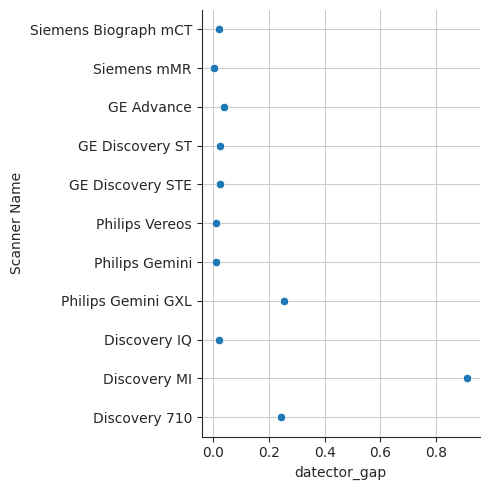

In [5]:
df\
.assign(datector_gap=(df["axial_fov"] - df["num_rings"] * df["z_crystal_size"]) / (df["num_rings"] - 1))\
.pipe(sns.relplot, y="Scanner Name", x="datector_gap")

## Coincidence window

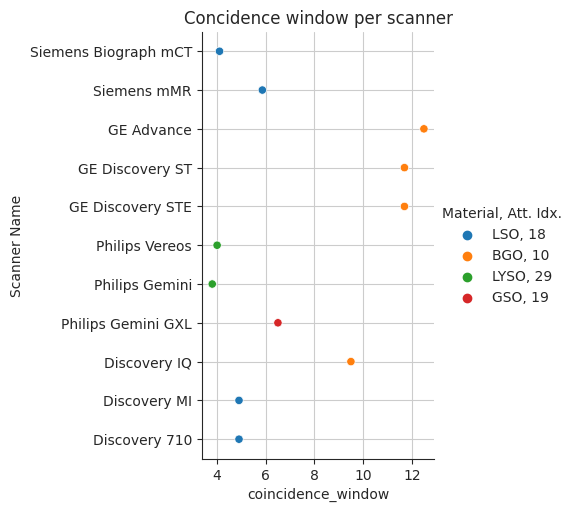

In [5]:
df.pipe(sns.relplot, y="Scanner Name", x="coincidence_window", hue="Material, Att. Idx.")\
    .set(title="Concidence window per scanner")

Text(0.5, 1.0, 'Average coincidence window per material')

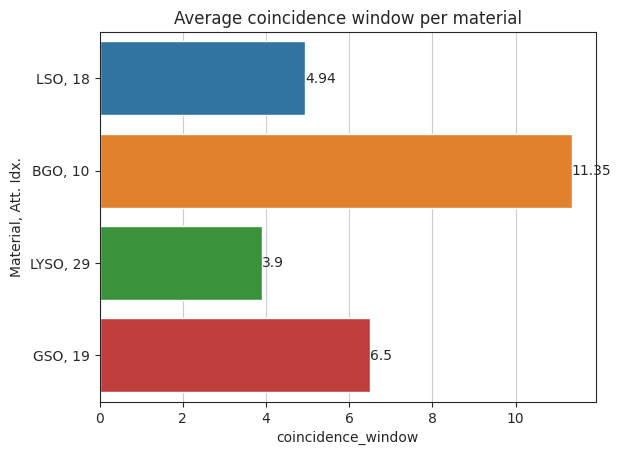

In [6]:
g = df.pipe(sns.barplot, y="Material, Att. Idx.", x="coincidence_window", estimator="mean", errorbar=None)
g.bar_label(g.containers[0])
g.set_title("Average coincidence window per material")

In [34]:
coincidence_window_per_material = df.groupby("Material, Att. Idx.").mean(numeric_only=True)["coincidence_window"].pipe(dict)

# Average DOI

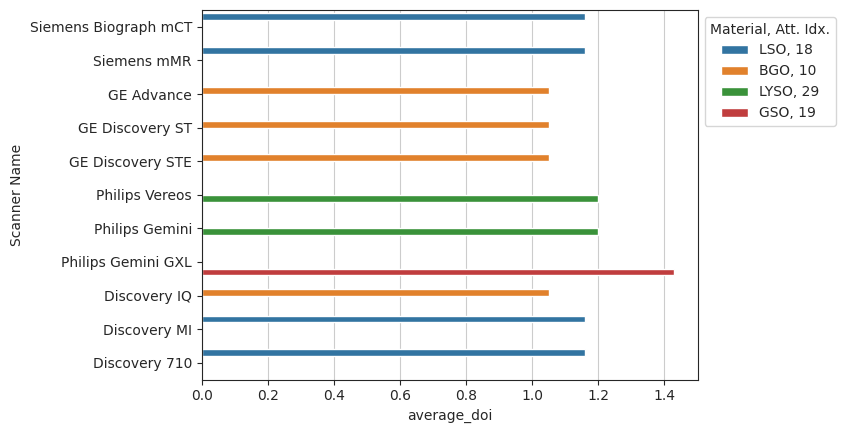

In [35]:
g = df.dropna(subset="average_doi")\
    .pipe(sns.barplot, y="Scanner Name", x="average_doi", hue="Material, Att. Idx.")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [36]:
averge_doi_material = df\
    .dropna(subset="average_doi")\
    .groupby(["Material, Att. Idx."])["average_doi"]\
    .agg(pd.Series.mode).to_frame()
averge_doi_material

,average_doi
"Material, Att. Idx.",
"BGO, 10",1.05
"GSO, 19",1.43
"LSO, 18",1.16
"LYSO, 29",1.20


In [37]:
average_doi = averge_doi_material.to_dict()["average_doi"]

avg_doi = {}
for k, v in average_doi.items():
    material = f"doi_{k.split(',')[0]}"

    if isinstance(v, Iterable):
        avg_doi[material] = float(round(statistics.mean(v), 2))
    else:
       avg_doi[material] = float(v) 

In [38]:
df[["Scanner Name", "Material, Att. Idx.", "average_doi"]].dropna(subset=["average_doi"])

,Scanner Name,"Material, Att. Idx.",average_doi
0,Siemens Biograph mCT,"LSO, 18",1.16
1,Siemens mMR,"LSO, 18",1.16
2,GE Advance,"BGO, 10",1.05
3,GE Discovery ST,"BGO, 10",1.05
4,GE Discovery STE,"BGO, 10",1.05
5,Philips Vereos,"LYSO, 29",1.20
6,Philips Gemini,"LYSO, 29",1.20
7,Philips Gemini GXL,"GSO, 19",1.43
8,Discovery IQ,"BGO, 10",1.05
9,Discovery MI,"LSO, 18",1.16


# Númber of `s` bins (`num_td_bins`)

/tmp/ipykernel_49464/439982568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_td_bins[f"ratio_{i}"] = DIAMETER_FRACCTION * mul * df_td_bins["scanner_radius"] / df_td_bins["transaxial_crystal_size"]
/tmp/ipykernel_49464/439982568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_td_bins[f"ratio_{i}"] = DIAMETER_FRACCTION * mul * df_td_bins["scanner_radius"] / df_td_bins["transaxial_crystal_size"]


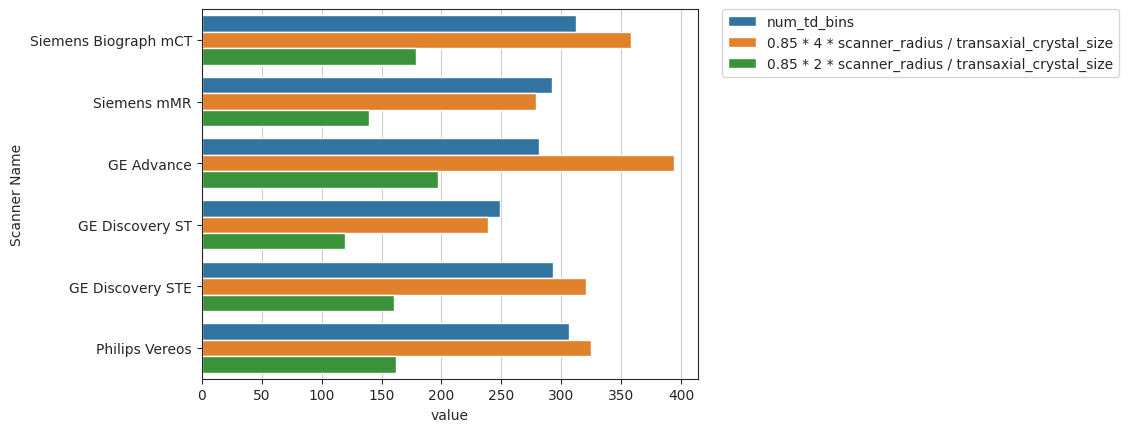

In [39]:
DIAMETER_FRACCTION = 0.85
MULT_SCANNER_RADIUS = [4, 2]

df_td_bins = df.dropna(subset=["num_td_bins"])

for i, mul in enumerate(MULT_SCANNER_RADIUS):
    df_td_bins[f"ratio_{i}"] = DIAMETER_FRACCTION * mul * df_td_bins["scanner_radius"] / df_td_bins["transaxial_crystal_size"]

g = df_td_bins\
    .pipe(pd.melt, id_vars=["Scanner Name"], value_vars=["num_td_bins", *[f"ratio_{i}" for i, _ in enumerate(MULT_SCANNER_RADIUS)]])\
    .replace({"variable": {
        (f"ratio_{i}"): (f"{DIAMETER_FRACCTION} * {mul} * scanner_radius / transaxial_crystal_size") for i, mul in enumerate(MULT_SCANNER_RADIUS)}})\
    .pipe(sns.barplot, x="value", y="Scanner Name", hue="variable")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Energy resolution

<AxesSubplot: xlabel='energy_resolution', ylabel='Scanner Name'>

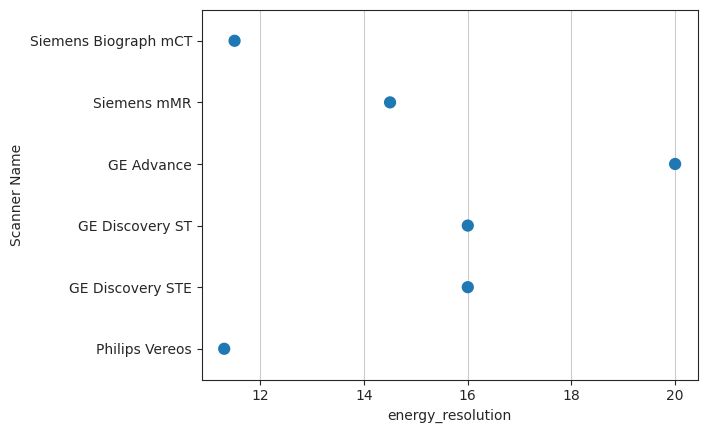

In [40]:
df.dropna().pipe(sns.pointplot, y="Scanner Name", x="energy_resolution", linestyles="")

<AxesSubplot: ylabel='energy_resolution'>

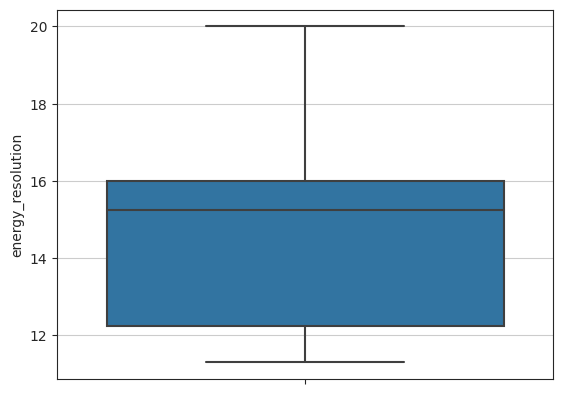

In [41]:
df.dropna().pipe(sns.boxplot, y="energy_resolution")

<AxesSubplot: xlabel='energy_resolution', ylabel='Count'>

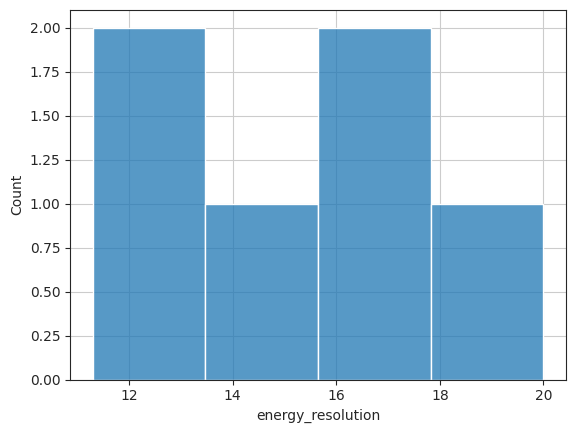

In [42]:
df.dropna().pipe(sns.histplot, x="energy_resolution")

## Material

<AxesSubplot: xlabel='Material, Att. Idx.', ylabel='P'>

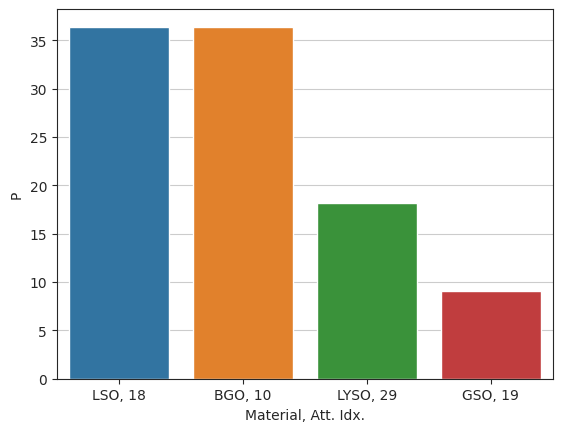

In [43]:
df_materials = df["Material, Att. Idx."]\
    .value_counts(normalize=True)\
    .rename_axis("Material, Att. Idx.")\
    .reset_index(name='P')
df_materials["P"] = (100 * df_materials["P"]).round(1)
df_materials.pipe(sns.barplot, x="Material, Att. Idx.", y ="P")


## Axial FOV

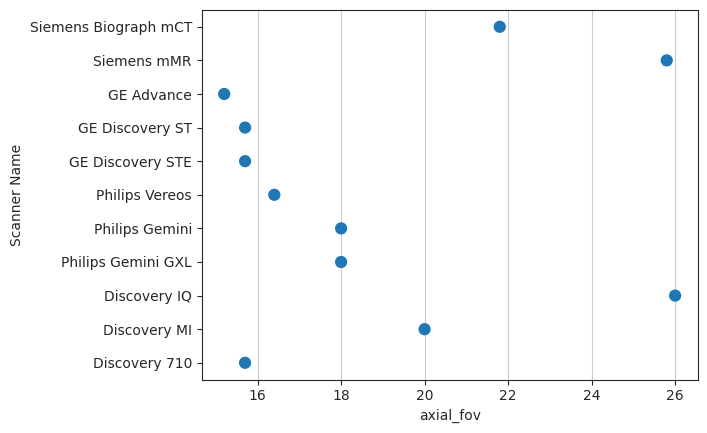

In [44]:
g = sns.pointplot(data=df, y="Scanner Name", x="axial_fov", linestyles="")

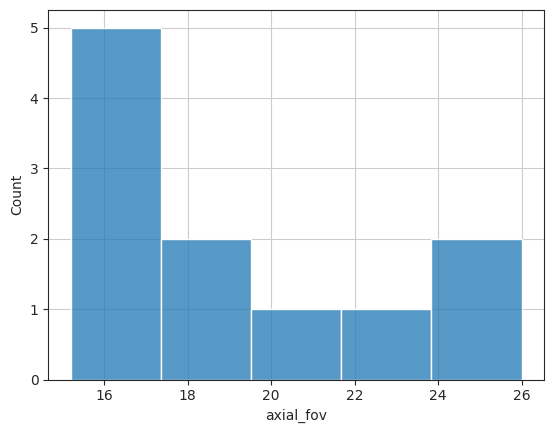

In [45]:
g = sns.histplot(data=df, x="axial_fov")

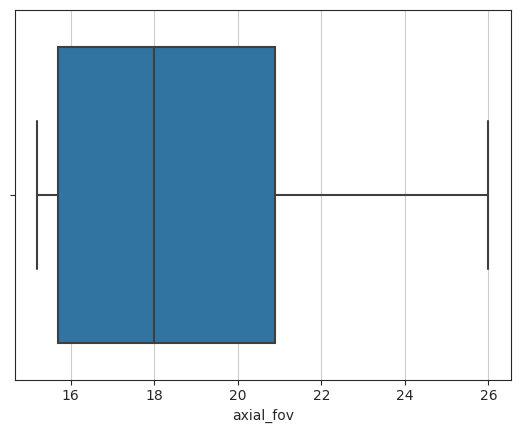

In [46]:
g = sns.boxplot(data=df, x="axial_fov")

## Cristal sizes

In [47]:
crystal_dims = [col for col in df.columns if bool(re.search(".*crystal.*", col))]
df[crystal_dims].describe().loc[["max", "mean", "min"], :].round(2)

,z_crystal_size,transaxial_crystal_size,crystal_thickness
max,0.81,0.63,3.00
mean,0.50,0.50,2.55
min,0.40,0.40,1.90


In [48]:
df_crystal = pd.melt(df, id_vars=["Scanner Name"], value_vars=crystal_dims).rename(columns={"variable": "Dim", "value": "Length"})

/home/yere/miniconda/envs/randfig/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


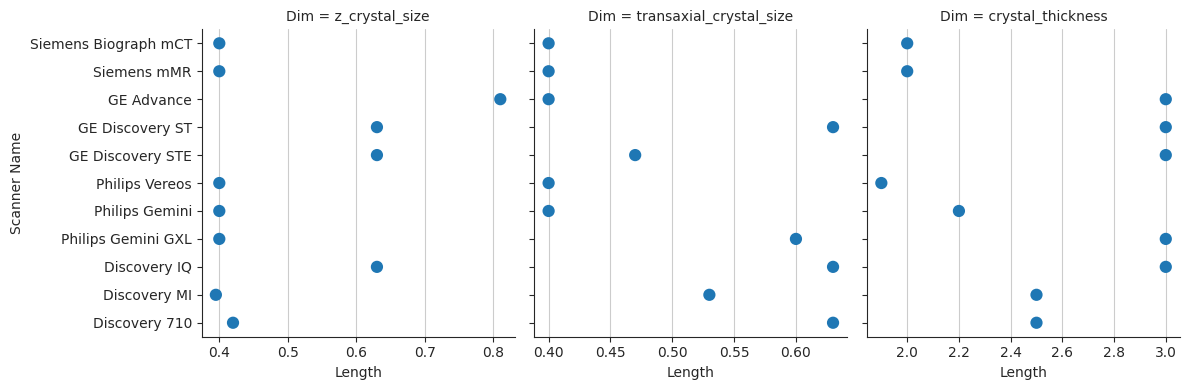

In [49]:
g = sns.FacetGrid(df_crystal, col="Dim", sharex=False, height=4, aspect=1)
g.map(sns.pointplot, "Length", "Scanner Name", linestyles="")

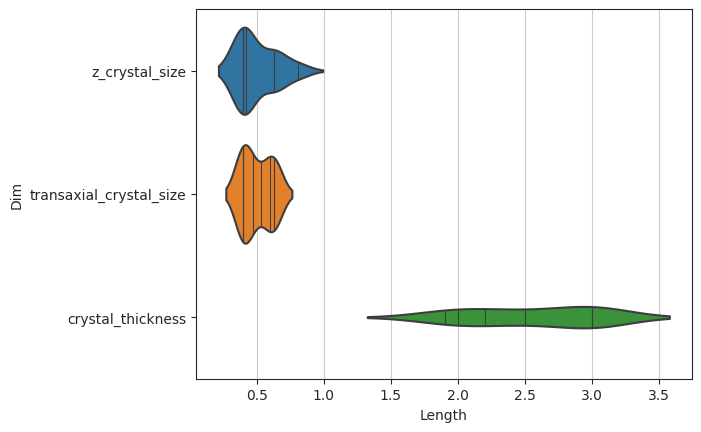

In [50]:
g = sns.violinplot(data=df_crystal, x="Length", y="Dim",  inner="stick", height=4, aspect=1)

## Save stats

In [51]:
EXCLUDED_MATERIALS = ["GSO"]

In [77]:
# Insert min-max params
min_max_params = [
    "energy_resolution", 
    "axial_fov",
    "scanner_radius",
    *crystal_dims
]

params = {k: v for k,v in avg_doi.items() if k.split("_")[1] not in EXCLUDED_MATERIALS}

for mvar in min_max_params:
    params[f"{mvar}_min"] = float(df[mvar].min())
    params[f"{mvar}_max"] = float(df[mvar].max())

In [78]:
# Insert material proportions
materials = df_materials["Material, Att. Idx."].tolist()
proportions = df_materials["P"].tolist()

for mat, prop in zip(materials, proportions):
    element, att_idx = mat.split(", ")
    
    if element not in EXCLUDED_MATERIALS:
        params[element] = att_idx
        params[f"p_{element}"] = float(prop)

In [79]:
for mat, time_w in coincidence_window_per_material.items():
    element, att_idx = mat.split(", ")

    if element not in EXCLUDED_MATERIALS:
        params[f"coincidence_window_{element}"] = float(time_w)

In [80]:
with open(STATS_PARAMS_FILE, 'w') as pf:
    yaml = ruamel.yaml.YAML()
    yaml.indent(sequence=4, offset=2)   
    yaml.dump(params, pf)